In [2]:
import pandas as pd
csv_path = 'vgsales.csv'
df = pd.read_csv(csv_path)

df.describe()

,Rank,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16598.000000,16327.000000,16598.000000,16598.000000,16598.000000,16598.000000,16598.000000
mean,8300.605254,2006.406443,0.264667,0.146652,0.077782,0.048063,0.537441
std,4791.853933,5.828981,0.816683,0.505351,0.309291,0.188588,1.555028
min,1.000000,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4151.250000,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8300.500000,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12449.750000,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,16600.000000,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [7]:
from sqlalchemy import create_engine, MetaData, Table, select, func
engine = create_engine('sqlite:///vgsales.db', echo=False)
df.to_sql('vgsales', engine, if_exists='replace', index=False)
metadata = MetaData()
vgsales = Table('vgsales', metadata, autoload_with=engine)
# Top-selling games by genre
stmt = (
    select(
        vgsales.c.Genre,
        func.sum(vgsales.c.Global_Sales).label('total_sales')
    )
    .group_by(vgsales.c.Genre)
    .order_by(func.sum(vgsales.c.Global_Sales).desc())
)

with engine.connect() as conn:
    print("Global Sales by Genre:")
    for genre, total in conn.execute(stmt):
        print(f"{genre:15} {total:.2f}M")

Global Sales by Genre:
Action          1751.18M
Sports          1330.93M
Shooter         1037.37M
Role-Playing    927.37M
Platform        831.37M
Misc            809.96M
Racing          732.04M
Fighting        448.91M
Simulation      392.20M
Puzzle          244.95M
Adventure       239.04M
Strategy        175.12M


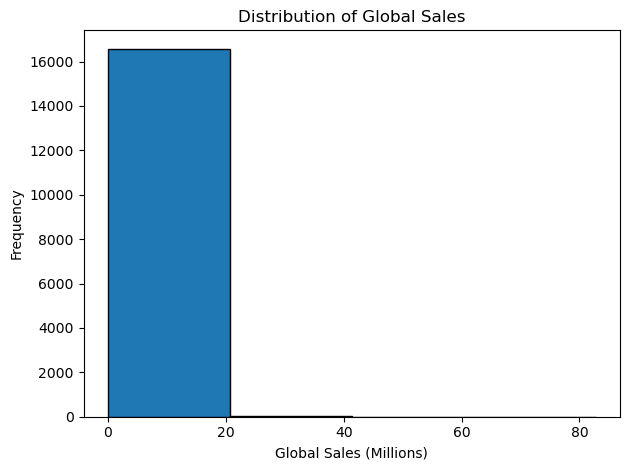

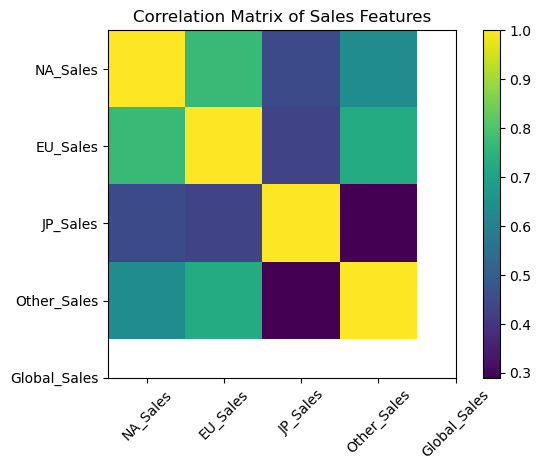

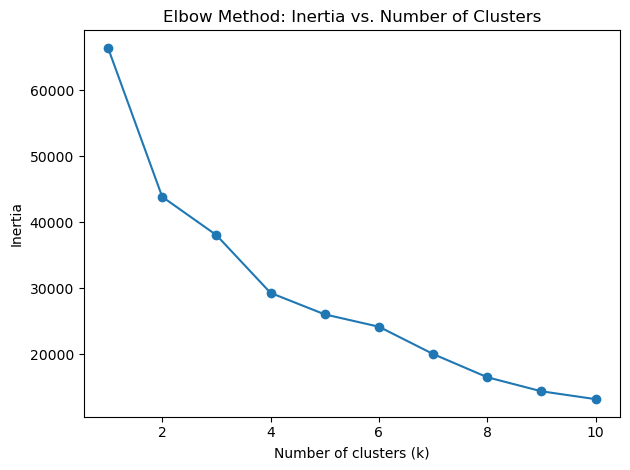

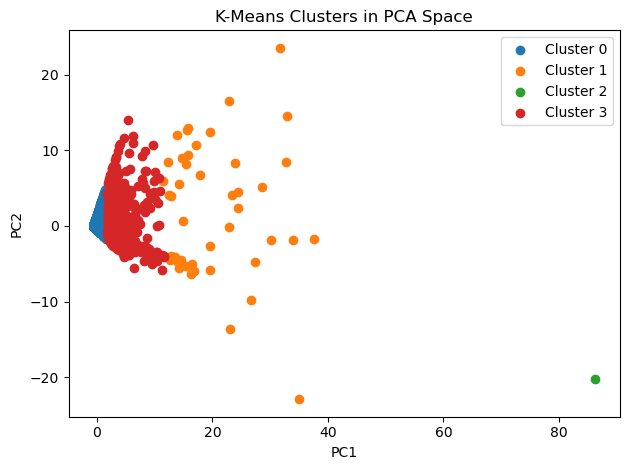

Silhouette Score for k=4: 0.8299


In [11]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sales_cols = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']
X = df[sales_cols].fillna(0)
features = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
X = df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Cell 2: Histogram of Global Sales
plt.figure()
plt.hist(df['Global_Sales'].dropna(), bins=4, edgecolor='black')
plt.title('Distribution of Global Sales')
plt.xlabel('Global Sales (Millions)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Cell 3: Correlation Heatmap
corr = X.corr()
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(sales_cols)), sales_cols, rotation=45)
plt.yticks(range(len(sales_cols)), sales_cols)
plt.title('Correlation Matrix of Sales Features')
plt.tight_layout()
plt.show()

# Cell 4: Elbow Method for K-Means
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertias = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(K_range, inertias, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.tight_layout()
plt.show()

# Cell 5: PCA Scatter of K-Means Clusters
best_k = 4  # adjust based on elbow
km = KMeans(n_clusters=best_k, random_state=42)
labels = km.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure()
for cluster_id in range(best_k):
    mask = labels == cluster_id
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=f'Cluster {cluster_id}')
plt.title('K-Means Clusters in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.tight_layout()
plt.show()

# Cell 6: Silhouette Score for best_k
score = silhouette_score(X_scaled, labels)
print(f'Silhouette Score for k={best_k}: {score:.4f}')